In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd

from random import random
from itertools import repeat

N = 10**3
A = [ [random() for i in range(N)] for j in range(N) ]
x = [random() for i in range(N)]

## In Serial

In [2]:
def in_serial(A,x):
    return [sum(a+b for a,b in zip(r,x)) for r in A ]

## In Parallel by Row

In [3]:
def sub_matrix_mult(i, A1, x1, ret):
    ret[i] = in_serial(A1,x1)

In [4]:
def sub_matrix_mult(i, A1, x1, ret):
    ret[i] = in_serial(A1,x1)

def in_parallel_row(A,x,p):
    manager = mp.Manager()
    ret = manager.list([0]*p)
    rows_per_proc = len(A)//p
    
    if N%p != 0:
        rows_per_proc += 1
    submatrices = [A[i:i+rows_per_proc] for i in range(0, N, rows_per_proc)]
    if len(submatrices)<p:
        submatrices += [A[rows_per_proc*(p-1):]]

    jobs = [mp.Process(target=sub_matrix_mult, 
            args=(i, submatrix, x, ret))
            for i, submatrix in enumerate(submatrices)]
    for job in jobs: job.start()
    for job in jobs: job.join()
    b = []
    for b1 in ret: b += b1
    return b

## In Parallel by Column

In [5]:
def add_matrices(matrices):
    rows = len(matrices[0])
    columns = len(matrices[0][0])
    return [ [ sum([A[i][j] for A in matrices]) for j in range(columns)] for i in range(rows) ]
def add_vectors(vectors):
    return [sum([v[i] for v in vectors]) for i in range(len(vectors[0]))]

In [6]:
def in_parallel_col(A,x,p):
    manager = mp.Manager()
    ret = manager.list([0]*p)
    
    if N%p == 0:
        cols_per_proc = len(A)//p
    else:
        cols_per_proc = len(A)//p + 1
    
    submatrices = [ [A[r][i*cols_per_proc:(i+1)*cols_per_proc]  for r in range(len(A))] for i in range(p-1)]
    subvectors = [x[i*cols_per_proc:(i+1)*cols_per_proc] for i in range(p-1)]
    
    if len(submatrices)<p:
        submatrices.append([ A[r][cols_per_proc*(p-1):] for r in range(len(A))])
        #submatrices += [ A[r][cols_per_proc*(p-1):] for r in range(len(A))]
        subvectors += [x[cols_per_proc*(p-1):]]     
        
    jobs = [mp.Process(target=sub_matrix_mult, 
            args=(i, submatrix, subvector, ret))
            for i, (submatrix, subvector) in enumerate(zip(submatrices, subvectors))]
    for job in jobs: job.start()
    for job in jobs: job.join()
    return add_vectors(ret)

# Times

In [11]:
N = 10**3
A = [ [random() for i in range(N)] for j in range(N) ]
x = [random() for i in range(N)]

columns = ['Time', 'Processors', 'Speed-Up', 'Efficiency', 'Theoretical Speed-Up', 'Theoretical Efficiency']
row_data = pd.DataFrame(columns=columns)
col_data = pd.DataFrame(columns=columns)

In [12]:
def stats_from_timeit(timeit_result, num_proc, description):
    t = timeit_result.best
    data_row = {'Time': t, 'Processors': num_proc}
    return pd.Series(data=data_row, name=description)

my_time = %timeit -o w = in_serial(A,x)
row_data = row_data.append(stats_from_timeit(my_time, 1, 'Serial'))
col_data = col_data.append(stats_from_timeit(my_time, 1, 'Serial'))
T0 = my_time.best

process_counts = range(0, int(np.log(mp.cpu_count())/np.log(2))+2)
process_counts = [2**p for p in process_counts]

for p in process_counts:
    my_time = %timeit -o w = in_parallel_row(A,x,p)
    row_data = row_data.append(stats_from_timeit(my_time, p, 'Parallel'))
    my_time = %timeit -o w = in_parallel_col(A,x,p)
    col_data = col_data.append(stats_from_timeit(my_time, p, 'Parallel'))

10 loops, best of 3: 105 ms per loop
1 loop, best of 3: 1.45 s per loop
1 loop, best of 3: 1.83 s per loop
1 loop, best of 3: 1.71 s per loop
1 loop, best of 3: 2.29 s per loop
1 loop, best of 3: 2.32 s per loop
1 loop, best of 3: 3.31 s per loop
1 loop, best of 3: 3.57 s per loop
1 loop, best of 3: 5.38 s per loop
1 loop, best of 3: 6.12 s per loop
1 loop, best of 3: 9.5 s per loop
1 loop, best of 3: 11.1 s per loop
1 loop, best of 3: 17.6 s per loop


In [13]:
row_data['Speed-Up'] = T0/row_data['Time']
row_data['Efficiency'] = row_data['Speed-Up']/row_data['Processors']
row_data['Theoretical Speed-Up'] = row_data['Processors']
row_data['Theoretical Efficiency'] = 1

col_data['Speed-Up'] = T0/col_data['Time']
col_data['Efficiency'] = col_data['Speed-Up']/col_data['Processors']
col_data['Theoretical Speed-Up'] = col_data['Processors']
col_data['Theoretical Efficiency'] = 1

In [14]:
row_data

,Time,Processors,Speed-Up,Efficiency,Theoretical Speed-Up,Theoretical Efficiency
Serial,0.104829,1.0,1.000000,1.000000,1.0,1
Parallel,1.453512,1.0,0.072121,0.072121,1.0,1
Parallel,1.706956,2.0,0.061413,0.030706,2.0,1
Parallel,2.321952,4.0,0.045147,0.011287,4.0,1
Parallel,3.568030,8.0,0.029380,0.003672,8.0,1
Parallel,6.120727,16.0,0.017127,0.001070,16.0,1
Parallel,11.098958,32.0,0.009445,0.000295,32.0,1


In [15]:
col_data

,Time,Processors,Speed-Up,Efficiency,Theoretical Speed-Up,Theoretical Efficiency
Serial,0.104829,1.0,1.000000,1.000000,1.0,1
Parallel,1.825134,1.0,0.057436,0.057436,1.0,1
Parallel,2.294158,2.0,0.045694,0.022847,2.0,1
Parallel,3.311359,4.0,0.031657,0.007914,4.0,1
Parallel,5.380530,8.0,0.019483,0.002435,8.0,1
Parallel,9.496522,16.0,0.011039,0.000690,16.0,1
Parallel,17.582664,32.0,0.005962,0.000186,32.0,1


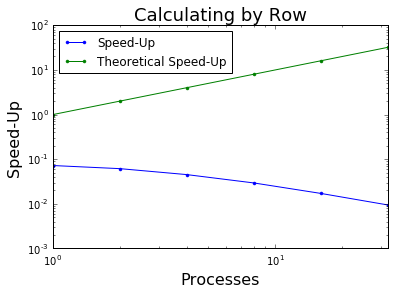

In [16]:
parallel_data = row_data.loc['Parallel'][['Processors','Speed-Up','Theoretical Speed-Up']]
plt = parallel_data.plot(x='Processors',style='.-', loglog=True)
plt.set_title('Calculating by Row',fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Speed-Up',fontsize=16);

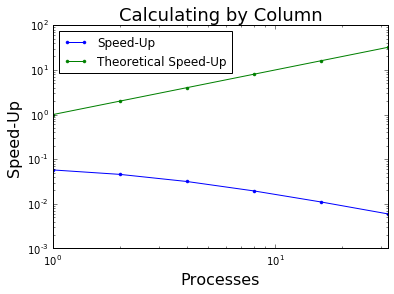

In [17]:
parallel_data = col_data.loc['Parallel'][['Processors','Speed-Up','Theoretical Speed-Up']]
plt = parallel_data.plot(x='Processors',style='.-', loglog=True)
plt.set_title('Calculating by Column',fontsize=18);
plt.set_xlabel('Processes',fontsize=16);
plt.set_ylabel('Speed-Up',fontsize=16);